<a href="https://colab.research.google.com/github/jahnvisikligar/Object-detection/blob/main/Object_detection_using_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Working with the dataset

In [4]:
import os
base_path="/content/drive/MyDrive/Datasets"
images=os.path.sep.join([base_path,'images'])
annotations=os.path.sep.join([base_path,'airplanes.csv'])

In [5]:
# Lets Load Dataset
# airplanes annotation is a Csv file thats why we can see through with rows

rows= open(annotations).read().strip().split("\n")

# lets make three list where we save our exact bounding boxes
data=[]
targets=[]
filenames=[]

In [6]:
#splitting of dataset
# import some usefull libraries
import cv2
from tensorflow.keras.preprocessing.image import load_img
# we also save images into array format so import img_array library too
from tensorflow.keras.preprocessing.image import img_to_array
for row in rows:
  row=row.split(",")
  # we always create rectangle with h+w so we have to know where exactly we should start from
  (filename,startX,startY,endX,endY)=row

  imagepaths=os.path.sep.join([images,filename])
  image=cv2.imread(imagepaths)
  (h,w)=image.shape[:2]

  # initializing starting point
  # Why we take in float because when we convert into array so then will trouble happen
  startX = float(startX) / w
  startY = float(startY) / h
  # Also initialize ending point
  endX = float(endX) / w
  endY = float(endY) / h
  #load image and give them default size
  image=load_img(imagepaths,target_size=(224,224))
  # see here if we cant take it into float then we face trouble
  image=img_to_array(image)

  # Lets append into data , targets ,filenames
  targets.append((startX,startY,endX,endY))
  filenames.append(filename)
  data.append(image)

In [7]:
# Normalizing Data here also we face would face issues if we take input as integer
import numpy as np
data=np.array(data,dtype='float32') / 255.0
targets=np.array(targets,dtype='float32')

In [8]:
#importing sklearn library to separate data into train and test data
from sklearn.model_selection import train_test_split

In [9]:
# split into testing and training
split=train_test_split(data,targets,filenames,test_size=0.10,random_state=42)

In [10]:
#split into steps
(train_images,test_images) = split[:2]
(train_targets,test_targets) = split[2:4]
(train_filenames,test_filenames) = split[4:]

Working with the model

In [11]:
#importing pre-trained VGG16 model forobject detection
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input

In [12]:
# Imagenet is a competition every year held and VGG16 is winner of between  2013-14
# so here we just want limited layers so thats why we false included_top
vgg=VGG16(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

In [13]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
from tensorflow.keras.layers import Input,Flatten,Dense

In [15]:
# we use VGG16 as per our requirement not use whole
vgg.trainable = False

flatten = vgg.output

flatten = Flatten()(flatten)

In [16]:
# Lets make bboxhead
bboxhead = Dense(128,activation="relu")(flatten)
bboxhead = Dense(64,activation="relu")(bboxhead)
bboxhead = Dense(32,activation="relu")(bboxhead)
bboxhead = Dense(4,activation="relu")(bboxhead)

In [17]:
# lets import Model
from tensorflow.keras.models import Model
model = Model(inputs = vgg.input,outputs = bboxhead)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
# fitting the model-Optimization
from tensorflow.keras.optimizers import Adam
opt=Adam(1e-4)

In [31]:
model.compile(loss='mse',optimizer=opt)

In [32]:
history = model.fit(train_images,train_targets,validation_data=(test_images,test_targets),batch_size=24,epochs=100,verbose=1)

Epoch 1/100
30/30 [==============================] - 4s 128ms/step - loss: 0.0111 - val_loss: 0.0123
Epoch 2/100
30/30 [==============================] - 3s 115ms/step - loss: 0.0120 - val_loss: 0.0124
Epoch 3/100
30/30 [==============================] - 3s 116ms/step - loss: 0.0122 - val_loss: 0.0128
Epoch 4/100
30/30 [==============================] - 4s 127ms/step - loss: 0.0125 - val_loss: 0.0121
Epoch 5/100
30/30 [==============================] - 4s 118ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 6/100
30/30 [==============================] - 4s 117ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/100
30/30 [==============================] - 4s 118ms/step - loss: 6.4385e-04 - val_loss: 9.0874e-04
Epoch 8/100
30/30 [==============================] - 4s 120ms/step - loss: 4.1032e-04 - val_loss: 8.7700e-04
Epoch 9/100
30/30 [==============================] - 4s 120ms/step - loss: 3.1374e-04 - val_loss: 8.3897e-04
Epoch 10/100
30/30 [==============================] - 4s 119ms/step

In [33]:
#saving the trained model
model.save('detect_Planes.h5')

In [34]:
from tensorflow.keras.models import load_model

In [35]:
model=load_model('/content/detect_Planes.h5')

Prediction checking

In [36]:
#inference checking to see if the model is able to produce the right outputs or not
imagepath='/content/drive/MyDrive/Datasets/images/image_0022.jpg'

In [37]:
image = load_img(imagepath,
                 target_size=(224,224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image,axis=0)

In [38]:
preds=model.predict(image)[0]
(startX,startY,endX,endY)=preds

1/1 [==============================] - 1s 983ms/step


In [39]:
import imutils

In [40]:
image=cv2.imread(imagepath)
image=imutils.resize(image,width=600)

In [41]:
(h,w)=image.shape[:2]

In [42]:
startX=int(startX * w)
startY=int(startY * h)

endX=int(endX * w)
endY=int(endY * h)

In [43]:
cv2.rectangle(image,(startX,startY),(endX,endY),(0,255,0),3)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [44]:
from google.colab.patches import cv2_imshow

-1

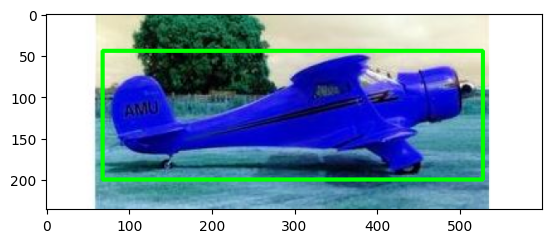

In [45]:
import matplotlib.pyplot as plt
plt.imshow(image)
cv2.waitKey(0)